In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import imutils
import tensorflow as tf
import keras
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, MaxPooling2D
from keras.models import Model

Using TensorFlow backend.


In [2]:
DATA_DIR = 'dataset/'
files_in_train = sorted(os.listdir(DATA_DIR))
images=[i for i in files_in_train]
df = pd.DataFrame()
df['label']=[str(x) for x in images]
df['image'] = [DATA_DIR + str(x) for x in images]
df['label'] = df['label'].str.rstrip('.png')

In [3]:
df.head()

,label,image
0,AAA,dataset/AAA.png
1,AAE,dataset/AAE.png
2,AAGL,dataset/AAGL.png
3,AAQI,dataset/AAQI.png
4,AAR,dataset/AAR.png


In [4]:
def resize_to_fit(image, width, height):
    (h, w) = image.shape[:2]
    if w > h:
        image = imutils.resize(image, width=width)
    else:
        image = imutils.resize(image, height=height)
    padW = int((width - image.shape[1]) / 2.0)
    padH = int((height - image.shape[0]) / 2.0)
    image = cv2.copyMakeBorder(image, padH, padH, padW, padW, cv2.BORDER_REPLICATE)
    image = cv2.resize(image, (width, height))
    return image

def preprocess_image(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV) 
    image[image==image[0,0]] = 255
    kernel_1 = np.ones((7,7), np.uint8) 
    kernel_2 = np.ones((4,4), np.uint8) 
    img_dilated_1 = cv2.dilate(image, kernel_1, iterations=1)
    image = cv2.cvtColor(img_dilated_1, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(image, (5,5), 0)
    retval_blur ,thresh_blur = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    image = cv2.bitwise_not(thresh_blur)
    cols = np.sum(image, axis=0)
    rows = np.sum(image, axis=1)
    flag = 0
    thresh = 255*5
    temp = 0
    start = []
    end = []
    for i in range(len(cols)):
        if cols[i] > thresh and flag==0:
            flag = 1
            temp = i
        if cols[i] <= thresh and flag==1:
            if (i-temp)>5 :
                start.append(temp)
                end.append(i)
            flag = 0
    char = np.zeros((len(start), 140, 140))
    for i in range(len(start)):
        l = end[i] - start[i]
        char[i][:, 75-(l//2):75+l-(l//2)] = image[5:-5,start[i]:end[i]]
    resized = np.zeros((len(start),30,30))
    for i in range(len(start)):
        char[i] = 255*np.ones((140,140)) - char[i]
        resized[i]=resize_to_fit(char[i], 30, 30)
    return resized

In [5]:
number = 0
X = np.zeros((8000, 30, 30))
Y = np.zeros((8000, 26))               
for i in range(len(df)):
    resized = preprocess_image(cv2.imread(df.iloc[i]['image']))
    index = 0
    for letter in resized:
        X[number] = letter
        Y[number][ord(df.iloc[i]['label'][index])- 65] = 1
        index += 1
        number += 1

In [6]:
training_size = 6800
X = X[:number,:,:]
X_train = X[:training_size,:,:]
X_test = X[training_size:,:,:]
Y = Y[:number,:]
Y_train = Y[:training_size,:]
Y_test = Y[training_size:,:]

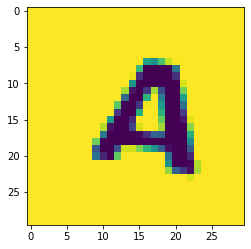

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [7]:
plt.imshow(X[1])
plt.show()
Y[1]

In [8]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(6800, 30, 30, 1)
(6800, 26)
(208, 30, 30, 1)
(208, 26)


In [9]:
X_train = X_train/255
X_test = X_test/255

In [10]:
def model_out(input_shape):
    X_Input = Input(input_shape)

    X = Conv2D(30, (5, 5), padding = "same", name = 'conv1')(X_Input)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2), name='max_pool_1')(X)

    X = Conv2D(50, (5, 5), padding = "same", name = 'conv2')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2), name='max_pool_2')(X)

    X = Flatten()(X)
    X = Dense(500, activation='relu', name='fc1')(X)
    X = Dense(26, activation='softmax', name='fc2')(X)

    model = Model(inputs = X_Input, outputs = X, name='decaptcha')
    return model

In [11]:
model = model_out(X_train.shape[1:])

In [12]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [13]:
model.fit(x = X_train, y = Y_train, batch_size=32, epochs=10, verbose=1)

Epoch 1/10
6800/6800 [==============================] - 16s 2ms/step - loss: 0.5961 - accuracy: 0.8391
Epoch 2/10
6800/6800 [==============================] - 5s 781us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 3/10
6800/6800 [==============================] - 5s 735us/step - loss: 3.9401e-04 - accuracy: 1.0000
Epoch 4/10
6800/6800 [==============================] - 5s 671us/step - loss: 2.0833e-04 - accuracy: 1.0000
Epoch 5/10
6800/6800 [==============================] - 4s 633us/step - loss: 1.3626e-04 - accuracy: 1.0000
Epoch 6/10
6800/6800 [==============================] - 4s 627us/step - loss: 8.9057e-05 - accuracy: 1.0000
Epoch 7/10
6800/6800 [==============================] - 4s 655us/step - loss: 6.3797e-05 - accuracy: 1.0000
Epoch 8/10
6800/6800 [==============================] - 4s 640us/step - loss: 4.7591e-05 - accuracy: 1.0000
Epoch 9/10
6800/6800 [==============================] - 5s 666us/step - loss: 3.6212e-05 - accuracy: 1.0000
Epoch 10/10
6800/6800 [==============

In [14]:
pred = model.evaluate(x = X_test,y = Y_test)
print()
print ("Loss = " + str(pred[0]))
print ("Test Accuracy = " + str(pred[1]))

208/208 [==============================] - 0s 495us/step

Loss = 2.435886919836496e-05
Test Accuracy = 1.0


In [15]:
model.save('submit/model.h5')